In [4]:
import xarray as xr 

ds = xr.open_dataset('soil-water-forecasting/modeling-pipeline/data/02_intermediate/preprocessed_data.nc', chunks="auto")

In [5]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:     (valid_time: 550, latitude: 180, longitude: 360)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-10-01
  * latitude    (latitude) int64 1kB -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude   (longitude) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
Data variables: (12/23)
    cl          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    rsn         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...          ...
    ssr         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    e           (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ro          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    swvl1       (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

Temporal Features

Lets add Seasonal Cycles

In [6]:
# Extract the season from the time coordinate
ds['season'] = ds['valid_time'].dt.season

In [7]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:     (valid_time: 550, latitude: 180, longitude: 360)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-10-01
  * latitude    (latitude) int64 1kB -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude   (longitude) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
Data variables: (12/24)
    cl          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    rsn         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...          ...
    e           (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ro          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    swvl1       (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    season      (valid_time) <U3 7kB 'DJF' 'DJF' 'MAM' ... 'JJA' 'SON' 'SON'
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [8]:
# Define a dictionary to map season strings to numerical values
season_mapping = {'DJF': 1, 'MAM': 2, 'JJA': 3, 'SON': 4}

# Convert the DataArray to a pandas Series, map the season names, and convert back to a DataArray
ds['season'] = ds['season'].to_series().map(season_mapping).to_xarray()

In [9]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:     (valid_time: 550, latitude: 180, longitude: 360)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-10-01
  * latitude    (latitude) int64 1kB -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude   (longitude) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
Data variables: (12/24)
    cl          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    rsn         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...          ...
    e           (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ro          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    swvl1       (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    season      (valid_time) int64 4kB 1 1 2 2 2 3 3 3 4 4 ... 1 2 2 2 3 3 3 4 4
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [10]:
# Broadcast 'season' to match dimensions (date, latitude, longitude)
season_broadcasted = ds['season'].expand_dims({'latitude': ds.latitude, 'longitude': ds.longitude})

# Add this expanded 'season' variable back to the dataset
ds['season'] = season_broadcasted

# Transpose 'season' to match the desired dimensions (date, latitude, longitude)
ds['season'] = ds['season'].transpose('valid_time', 'latitude', 'longitude')

In [11]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:     (valid_time: 550, latitude: 180, longitude: 360)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-10-01
  * latitude    (latitude) int64 1kB -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude   (longitude) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
Data variables: (12/24)
    cl          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    rsn         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...          ...
    e           (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ro          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    swvl1       (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    season      (valid_time, latitude, longitude) int64 285MB 1 1 1 1 ... 4 4 4
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [12]:
# Convert season to int8
ds['season'] = ds['season'].astype('int32')

In [13]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:     (valid_time: 550, latitude: 180, longitude: 360)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-10-01
  * latitude    (latitude) int64 1kB -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude   (longitude) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
Data variables: (12/24)
    cl          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    rsn         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...          ...
    e           (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ro          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    swvl1       (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    season      (valid_time, latitude, longitude) int32 143MB 1 1 1 1 ... 4 4 4
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

tp_minus_E_cumulative total precipitation minus evaportaion 

calaculate specific humidity from 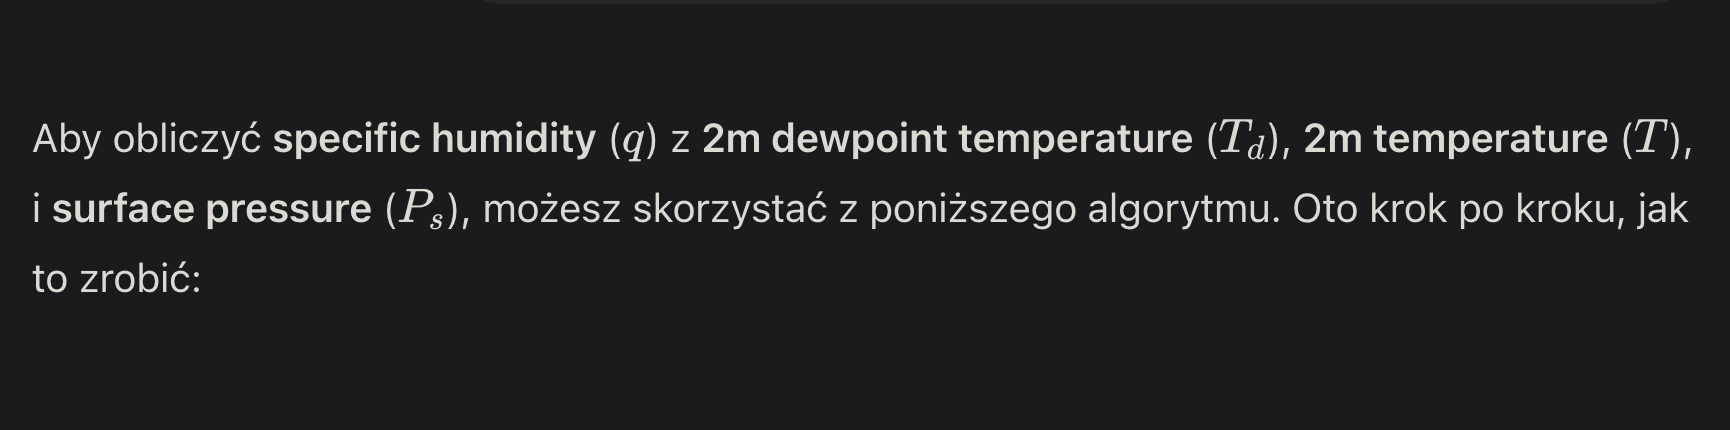
 

Soil Moisture Dynamics

Evapotranspiration Balance: Calculate a moisture balance feature as tp - e (precipitation minus evaporation). This balance can serve as an indicator of moisture availability and stress, especially over rolling windows.

Wind Impact: Combine u10 and v10 (wind components) to create a wind speed variable to assess the drying effect of wind on soil moisture.

Determine Wind Direction: Calculate the wind direction using: Wind speed and direction influence evapotranspiration rates, affecting soil moisture levels.

Temperature Anomalies: Identify deviations from long-term average temperatures to capture unusual thermal conditions impacting soil moisture.

In [14]:
ds.to_netcdf('soil-water-forecasting/modeling-pipeline/data/04_feature/features.nc')